In [1]:
import sys
import numpy as np
import math
import ceo
%pylab inline
%run GMT-DOS-Estimation-SAO.py

Populating the interactive namespace from numpy and matplotlib


In [2]:
nPx = N_PX_LENLSET*N_LENSLET+1
print "pupil sampling:      %d pixel"%nPx
detectorRes = 2.0*N_PX_LENLSET*N_LENSLET/2.0
print "detector resolution: %d pixel"%detectorRes
zenith_angle  = np.ones((1,N_GS))*zenith_distance_arcmin*ceo.constants.ARCMIN2RAD # in radians
azimuth_angle = np.arange(N_GS)*360.0/N_GS # in degrees
gs    = ceo.Source(AGWS_photometric_band,
                   zenith=zenith_angle,azimuth=azimuth_angle*math.pi/180,
                   rays_box_size=entrance_pupil_size_meter,
                   rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
wfs = ceo.ShackHartmann(N_LENSLET, N_PX_LENLSET, lenslet_pitch_meter, 
                        N_PX_IMAGE=2*N_PX_LENLSET,BIN_IMAGE=2,N_GS=N_GS)
gmt = ceo.GMT_MX(entrance_pupil_size_meter,nPx,M1_radial_order=M1_zernike_radial_order)

pupil sampling:      469 pixel
detector resolution: 468 pixel


In [3]:
gs.wavelength*ceo.constants.RAD2ARCSEC/2

0.06600473759792895

In [4]:
from scipy.optimize import brentq
def ee80(_psf_,_px_scale_):
    n,m = _psf_.shape
    u = np.linspace(-1,1,n)*(n/2)
    v = np.linspace(-1,1,m)*(m/2)
    x,y = np.meshgrid(u,v)
    def ee80_fun(ee_Delta):
        _ee_Delta_ = (ee_Delta-1)/2
        gate = np.logical_and(np.abs(x)<=_ee_Delta_,np.abs(y)<=_ee_Delta_)
        return np.sum(psf*gate)/(src.nPhoton*368) - 0.8
    try:
        q = brentq(ee80_fun,1,81)*_px_scale_*ceo.constants.RAD2MAS
    except ValueError:
        q = np.float('inf')
    return q

pixel size: 1.27mas


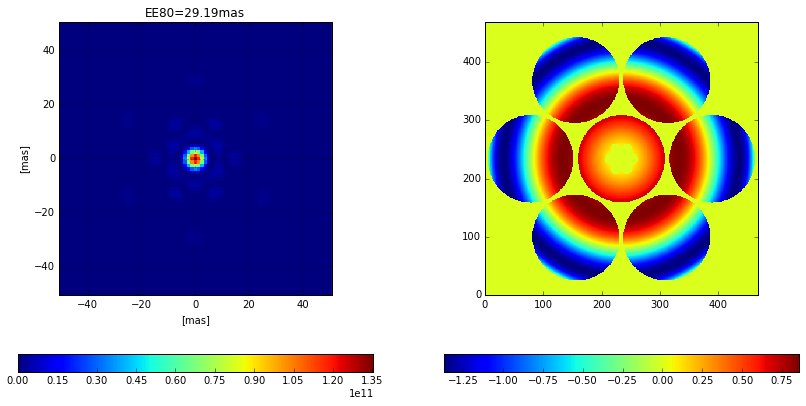

In [5]:
src = ceo.Source(S_photometric_band,
                 rays_box_size=entrance_pupil_size_meter,
                 rays_box_sampling=nPx,rays_origin=[0.0,0.0,25])
gmt.reset()
gmt.propagate(src)
imgr = ceo.Imaging(1, nPx-1,DFT_osf=2*nyquist_oversampling_factor,
                   N_PX_IMAGE=detector_resolution,N_SOURCE=src.N_SRC)
imgr.propagate(src)
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
fig.set_size_inches((14,7))
psf = imgr.frame.host()
px_scale = src.wavelength/(entrance_pupil_size_meter*4)
h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ee80_0 = ee80(psf,px_scale)
ax1.set_title("EE80=%.2fmas"%ee80_0)
colorbar(h1,ax=ax1,orientation='horizontal')
h2 = ax2.imshow(src.wavefront.phase.host(shape=(nPx*src.N_SRC,nPx),units='nm').T,interpolation='none',origin='lower')
colorbar(h2,ax=ax2,orientation='horizontal')
print "pixel size: %.2fmas"%(px_scale*ceo.constants.RAD2MAS)

#Calibrations
## Wavefront sensors

[ 1277.90515137]


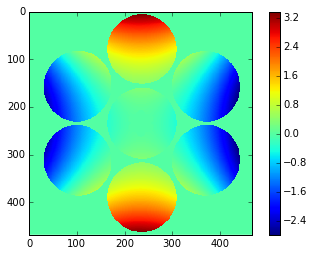

In [6]:
#gmt.M1.update(origin=[0e-6,0.0,0.0],idx=1)
#gs.reset()
gmt.reset()
gs.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
imshow(ps0,interpolation='None')
colorbar()
print gs.wavefront.rms()*1e9
wfs.calibrate(gs,0.8)

In [7]:
print wfs.frame.shape
print "Pixel size: %.3farcsec"%(wfs.pixel_scale_arcsec)
print "Field of view: %.3farcsec"%(wfs.pixel_scale_arcsec*wfs.N_PX_IMAGE/2)

(468, 468)
Pixel size: 0.132arcsec
Field of view: 2.376arcsec


12000.4795761
4000.15985869
3647.3054167
4443.38064589


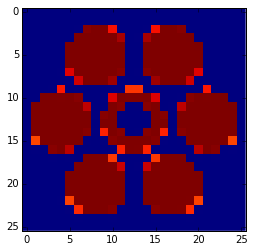

In [8]:
imshow(wfs.flux.host().T,interpolation='none')
print src.nPhoton*1e-9*368*3
print gs.nPhoton*1e-9*368
wfs.analyze(gs)
print wfs.flux.host().sum()*1e-9
print wfs.frame.host().sum()*1e-9

### Segment tip-tilt sensor

In [9]:
sts = ceo.SegmentTipTiltSensor()
gs.reset()
gmt.reset()
gmt.propagate(gs)
a230 = sts.tiptilt(gs)

## M2 tip-tilt

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------
M2 tip-tilt interaction matrix condition #:   1.08


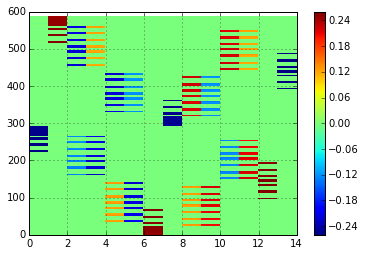

In [10]:
D2tt = gmt.calibrate(wfs,gs,mirror="M2",mode="segment tip-tilt",stroke=200*ceo.constants.MAS2RAD)
fig, ax = subplots()
h = ax.pcolor(D2tt)
colorbar(h)
grid()
print "M2 tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D2tt)

## M2 x,y,z translations with M2 segment tip-til removed

In [11]:
mic2m = 1e-6
def M2_xyz(xyz,segId):
    gmt.reset()
    gmt.M2.update(origin=xyz,idx=segId)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [12]:
def M2_seg_TT(origin=[0,0,0],originId=0):
    M = np.linalg.pinv(D2tt)
    M2_R = np.zeros((14,1))
    for kStep in range(4):
        M2_R += np.dot(M,wfs.valid_slopes.host().T)
    #    print M2_R/mas2rad
    #    print M2_R.shape
        for k in range(7):
            R = [-M2_R[2*k,0],-M2_R[2*k+1,0],0]
            if originId==(k+1):
                gmt.M2.update(origin=origin,euler_angles=R,idx=k+1)
            else:
                gmt.M2.update(euler_angles=R,idx=k+1)
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        wfs.analyze(gs)
#    imshow(1e3*wfs.c.host(shape=(nLenslet*2,nLenslet),units='arcsec').T,interpolation='none')
#    colorbar()
    return wfs.valid_slopes.host().ravel()

In [13]:
stroke = 10
c_shape = (gs.N_SRC*N_LENSLET*2,N_LENSLET)
cp_x = cm_x = np.zeros(shape=c_shape)
cp_y = cm_y = np.zeros(shape=c_shape)
cp_z = cm_z = np.zeros(shape=c_shape)
ps_x = ps_y = ps_z = np.zeros(shape=gs.phase.shape)
D2xyz_2 = np.zeros((wfs.n_valid_slopes,3*7))
l = -1
sys.stdout.write("Segment #: ")
for k in range(1,8):
    sys.stdout.write("%d "%k)
    xyz = [stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_x = cp_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    
    ps_x = ps_x + mask*(ps - ps0)
    xyz = [-stroke*mic2m,0,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_x = cm_x + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,stroke*mic2m,0]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_y = cp_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_y = ps_y + mask*(ps - ps0)
    xyz = [0,-stroke*mic2m,0]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_y = cm_y + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

    xyz = [0,0,stroke*mic2m]
    M2_xyz(xyz,k)
    sp = M2_seg_TT(origin=xyz,originId=k)
    cp_z = cp_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    ps = gs.phase.host(units='micron')
    mask = np.logical_and( np.abs(ps) , np.abs(ps0) )
    ps_z = ps_z + mask*(ps - ps0)
    xyz = [0,0,-stroke*mic2m]
    M2_xyz(xyz,k)
    sm = M2_seg_TT(origin=xyz,originId=k)
    cm_z = cm_z + 1e3*wfs.c.host(shape=c_shape,units='arcsec')
    l += 1
    D2xyz_2[:,l] = ((sp-sm)/2)/(mic2m*stroke)    

Segment #: 1 2 3 4 5 6 7 

<matplotlib.colorbar.Colorbar instance at 0x2acc42ba29e0>

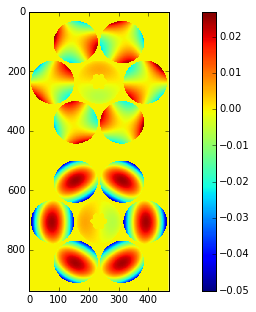

In [14]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
#h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

<matplotlib.colorbar.Colorbar instance at 0x2acc439add40>

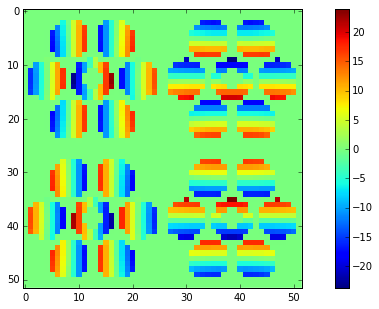

In [15]:
fig, ax2 = subplots()
fig.set_size_inches(12,5)
h2=ax2.imshow(np.concatenate((cp_z,cm_z),axis=1).T,interpolation='none')
#h2=ax2.imshow(np.concatenate((ps_x,ps_y),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)

M2 x,y,x translation interaction matrix condition #:  41.48


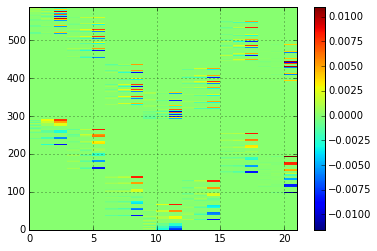

In [16]:
fig, ax = subplots()
h = ax.pcolor(D2xyz_2)
colorbar(h)
axis("tight")
grid()
print "M2 x,y,x translation interaction matrix condition #: %6.2f"%np.linalg.cond(D2xyz_2)

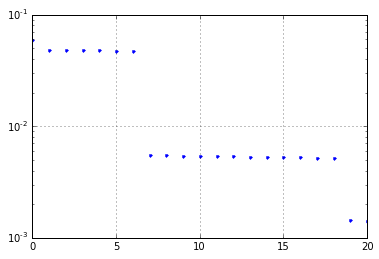

In [17]:
D =  ( D2xyz_2  )
U,S,V = np.linalg.svd(D)
semilogy(S,'.')
grid()

## M1 global tip-tilt with M2 segment tip-til removed

In [18]:
mas2rad = 1e-3*math.pi/180/3600
def M1_global_TT(tip,tilt):
    gmt.reset()
    gmt.M1.global_tiptilt(tip,tilt)
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

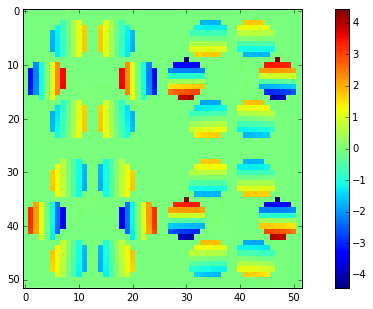

In [19]:
amp = 50*ceo.constants.MAS2RAD
M1_global_TT(amp,0)
sp = M2_seg_TT()
fig, ax2 = subplots()
fig.set_size_inches(12,5)
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
M1_global_TT(-amp,0)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2 = np.zeros((wfs.n_valid_slopes,2))
D1gtt_2[:,0] = ((sp-sm)/2)/amp

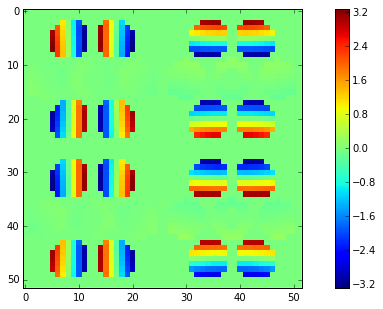

In [20]:
M1_global_TT(0,amp)
sp = M2_seg_TT()
cp = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
fig, ax2 = subplots()
fig.set_size_inches(12,5)
M1_global_TT(0,-amp)
sm = M2_seg_TT()
cm = 1e3*wfs.c.host(shape=(gs.N_SRC*N_LENSLET*2,N_LENSLET),units='arcsec')
h2=ax2.imshow(np.concatenate((cp,cm),axis=1).T,interpolation='none')
colorbar(h2,ax=ax2)
D1gtt_2[:,1] = ((sp-sm)/2)/amp

M1 global tip-tilt interaction matrix condition #:   1.01


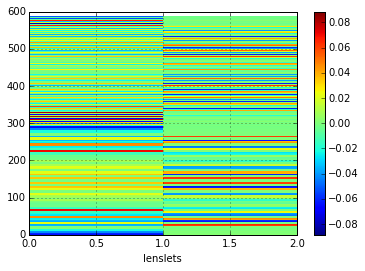

In [21]:
pcolor(D1gtt_2)
grid()
xlabel('lenslets')
colorbar()
print "M1 global tip-tilt interaction matrix condition #: %6.2f"%np.linalg.cond(D1gtt_2)

## M1 bending modes

In [22]:
mic2m = 1e-6
def M1_zern(zmode,zstroke,segId):
    gmt.reset()
    gmt.M1.zernike.a[segId,zmode] = zstroke
    gmt.M1.zernike.update()
    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.analyze(gs)
#    plot(wfs.valid_slopes.host().ravel())
#    grid()

In [23]:
zStroke = 1e-7
l = -1
zmodes = [4,5]
zmodes.extend(range(6,10))
nZernCoefs = len(zmodes)
D1z_2 = np.zeros((wfs.n_valid_slopes,7*nZernCoefs))
ps_z = np.zeros(shape=gs.phase.shape)
for kSeg in range(7):
    sys.stdout.write("Segment #%d: "%kSeg)
    for kMode in zmodes:
        sys.stdout.write("%d "%(kMode+1))
        M1_zern(kMode,zStroke,kSeg)
        sp = M2_seg_TT()
        M1_zern(kMode,-zStroke,kSeg)
        sm = M2_seg_TT()
        l += 1
        D1z_2[:,l] = ((sp-sm)/2)/(zStroke)   
    #ps_z = ps_z + gs.phase.host(units='micron') - ps0
    sys.stdout.write("\n")

Segment #0: 5 6 7 8 9 10 
Segment #1: 5 6 7 8 9 10 
Segment #2: 5 6 7 8 9 10 
Segment #3: 5 6 7 8 9 10 
Segment #4: 5 6 7 8 9 10 
Segment #5: 5 6 7 8 9 10 
Segment #6: 5 6 7 8 9 10 


Zernike modes interaction matrix condition #:   1.97


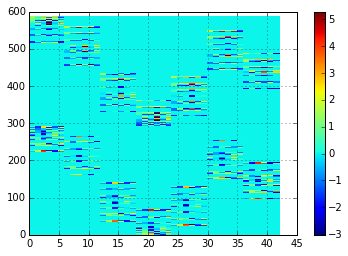

In [24]:
fig, ax = subplots()
h = ax.pcolor(D1z_2)
colorbar(h)
grid()
print "Zernike modes interaction matrix condition #: %6.2f"%np.linalg.cond(D1z_2)

___ M2 ___
Segment #:1 2 3 4 5 6 7 
------------


<matplotlib.colorbar.Colorbar instance at 0x2acc50333908>

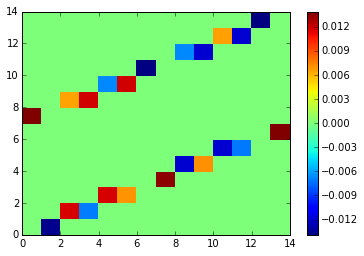

In [25]:
D2tt7 = gmt.calibrate(sts,gs,mirror='M2',mode='geometric segment tip-tilt',
                 stroke=1*ceo.constants.ARCSEC2RAD)
pcolor(D2tt7)
colorbar()

In [26]:
import scipy.io as io
data = {}
data['D1z_2']=D1z_2
data['D1gtt_2']=D1gtt_2
data['D2tt']=D2tt
data['D2tt7']=D2tt7
data['D2xyz_2']=D2xyz_2
io.savemat('GMT-DOS-Estimation-SAO.mat',data)

# AGWS estimation

<matplotlib.colorbar.Colorbar instance at 0x2b584793dd40>

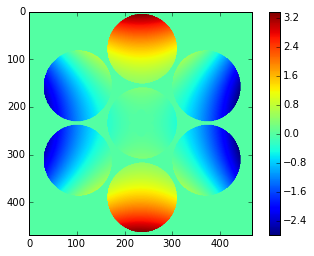

In [26]:
from ceo.constants import ARCSEC2RAD, MAS2RAD
gs.reset()
gmt.reset()
gmt.propagate(gs)
ps0 = gs.phase.host(units='micron')
P0 = gs.amplitude.host()
imshow(ps0)
colorbar()

## Condition numbers of interaction matrices

In [27]:
print "M2 segment tilts: %2.0f"%cond(D2tt)
print "M1 global tilts : %2.0f"%cond(D1gtt_2)
print "M2 Tx, Ty and Tz: %2.0f"%cond(D2xyz_2)
print "M1 Zernikes     : %2.0f"%cond(D1z_2)
print "M1 global tilts  + M2 Tx, Ty and Tz: %5.0f"%cond(np.concatenate((D1gtt_2,D2xyz_2),axis=1))
print "M1 global tilts  + M1 Zernikes     : %5.0f"%cond(np.concatenate((D1gtt_2,D1z_2),axis=1))
print "M2 Tx, Ty and Tz + M1 Zernikes     : %5.0f"%cond(np.concatenate((D2xyz_2,D1z_2),axis=1))
print "M1 global tilts  + M2 Tx, Ty and Tz + M1 Zernikes: %5.0f"%cond(np.concatenate((D1gtt_2,D2xyz_2,D1z_2),axis=1))

M2 segment tilts:  1
M1 global tilts :  1
M2 Tx, Ty and Tz: 41
M1 Zernikes     :  2
M1 global tilts  + M2 Tx, Ty and Tz:  1613
M1 global tilts  + M1 Zernikes     :    25
M2 Tx, Ty and Tz + M1 Zernikes     : 1336578
M1 global tilts  + M2 Tx, Ty and Tz + M1 Zernikes: 1337073


## M1 global tip-tilt estimation

Applying 1/4" of M1 global tilt

In [35]:
gmt.reset()
M1_gtt_int = np.zeros(2)
M1_gtt0 = np.array([0.25,0])*ARCSEC2RAD
gmt.M1.global_tiptilt(M1_gtt0[0],M1_gtt0[1])

and propagation to the WFS

on-axis WFE: 14.22 micron


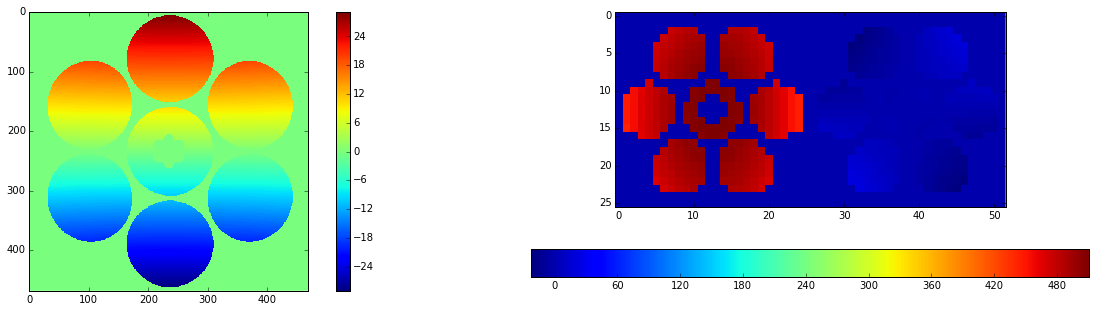

In [36]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts which are expected to be 8 times the M1 tilts each:

In [148]:
M2tt7 = pinv(D2tt7)
a23 = np.dot(M2tt7,np.ravel(sts.tiptilt(gs)-a230))
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(a23.reshape(7,-1)/ARCSEC2RAD,precision=2,suppress_small=True)
M2_stt = a23
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)

M2 segment tip-tilt [MAS] ([x,y] and magnitude):
[[-2.01  0.15]
 [-1.03 -1.78]
 [ 0.97 -1.68]
 [ 1.78  0.15]
 [ 0.87  1.74]
 [-0.93  1.84]
 [ 1.99  0.  ]]


In [39]:
M2tt = pinv(D2tt)
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/ARCSEC2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

M2 segment tip-tilt [MAS] ([x,y] and magnitude):
[[-1.84 -0.  ]
 [-0.92 -1.73]
 [ 0.92 -1.73]
 [ 1.84 -0.  ]
 [ 0.92  1.72]
 [-0.92  1.72]
 [ 1.99  0.  ]]
[ 1.84200442  1.95604692  1.95593209  1.84232122  1.95138568  1.9514797
  1.98941215]


and propagation again:

on-axis WFE: 13.44 micron


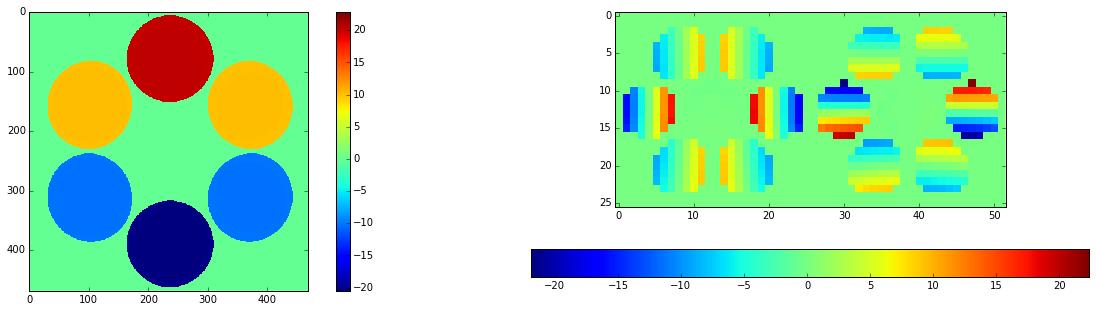

In [40]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Finally, estimation of M1 global tip-tilt with:
 * M1 global tiptilt interaction matrix alone

In [52]:
M1gtt_2 = pinv(D1gtt_2)
M1_gtt_est = np.dot(M1gtt_2,wfs.valid_slopes.host().ravel())
print "M1 global tip-tilt est.: " + array_str(M1_gtt_est/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M1_idx = np.abs(M1_gtt_est)>0.1*ARCSEC2RAD
M1_gtt_est[M1_idx] = np.sign(M1_gtt_est[M1_idx])*0.1*ARCSEC2RAD
M1_gtt_int += M1_gtt_est
print "M1 global tip-tilt int.: " + array_str(M1_gtt_int/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M1_gtt = M1_gtt0 - M1_gtt_int
gmt.M1.global_tiptilt(M1_gtt[0],M1_gtt[1])
print "M1 global tip-tilt com.: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"

M1 global tip-tilt est.: [ 0.25    0.0001] arcsec
M1 global tip-tilt int.: [ 0.2     0.0001] arcsec
M1 global tip-tilt com.: [ 0.05   -0.0001] arcsec


* M1 global tiptilt interaction matrix concatenated with M2 Tx,Ty and Tz interaction matrix 

In [53]:
D12 = np.concatenate((D1gtt_2,D2xyz_2),axis=1)
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M2_txyz = com12[2:].reshape(7,-1)
for k in range(7):
    gmt.M2.update(origin = M2_txyz[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [nm]:"
print array_str(1e9*M2_txyz,precision=0,suppress_small=True)

M1 global tip-tilt: [ 0.2475 -0.0049] arcsec
M2 Tx,Ty,Tz [nm]:
[[   7.   38. -222.]
 [  91.   52.  115.]
 [-117.   23.  225.]
 [  -5.  150.  -43.]
 [ 129.   89. -140.]
 [-124.   71. -240.]
 [ -15.   -9.   -6.]]


* M1 global tiptilt interaction matrix concatenated with M2 Tx,Ty and Tz and M1 Zernike modes interaction matrices 

In [54]:
D12 = np.concatenate((D1gtt_2,D2xyz_2,D1z_2),axis=1)
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M2_txyz = com12[2:23].reshape(7,-1)
for k in range(7):
    gmt.M2.update(origin = M2_txyz[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [nm]:"
print array_str(1e9*M2_txyz,precision=0,suppress_small=True)
gmt.M1.zernike.a = com12[23:].reshape(7,-1)
gmt.M1.zernike.update()
print "M1 Zernike modes [nm]:"
print np.array_str(1e9*com12[23:].reshape(7,-1),precision=0,suppress_small=True)

M1 global tip-tilt: [ 0.0762  0.0705] arcsec
M2 Tx,Ty,Tz [nm]:
[[  2907. -15266.  -3790.]
 [ -3017.   -331.  -5927.]
 [  1592.    130.   1129.]
 [ -1146. -18205.  11147.]
 [ -9122.  -3147.   6924.]
 [  8681.  -3643.   -113.]
 [   -72.   -887.     81.]]
M1 Zernike modes [nm]:
[[ -1.  -9.   1.  -0.  -0.  -0.]
 [  0.   2.  -0.   0.  -0.   0.]
 [  1.   1.   0.   0.   0.   0.]
 [  1. -10.  -1.  -0.  -0.   0.]
 [ -1.   6.   1.  -1.  -0.   0.]
 [  1.   6.  -0.  -1.  -0.  -0.]
 [  0.   0.  -0.  -0.  -0.  -0.]]


Compensation with M1 global tip

on-axis WFE: nan micron


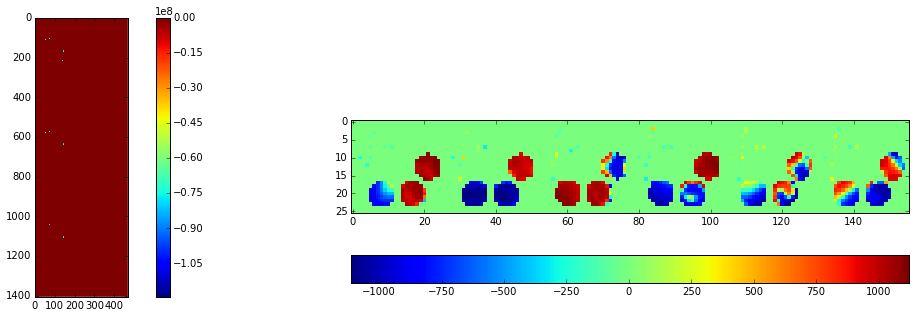

In [47]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts which are expected to be 0" each:

In [48]:
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/ARCSEC2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

M2 segment tip-tilt [MAS] ([x,y] and magnitude):
[[-6.77  3.79]
 [-1.7  -9.03]
 [ 4.89 -3.71]
 [ 4.97  0.57]
 [ 2.39  5.38]
 [-2.48  5.86]
 [ 6.4  -0.  ]]
[ 7.7586629   9.18466579  6.14161732  5.00392173  5.88665885  6.36135351
  6.39927911]


and propagation again:

on-axis WFE: nan nm


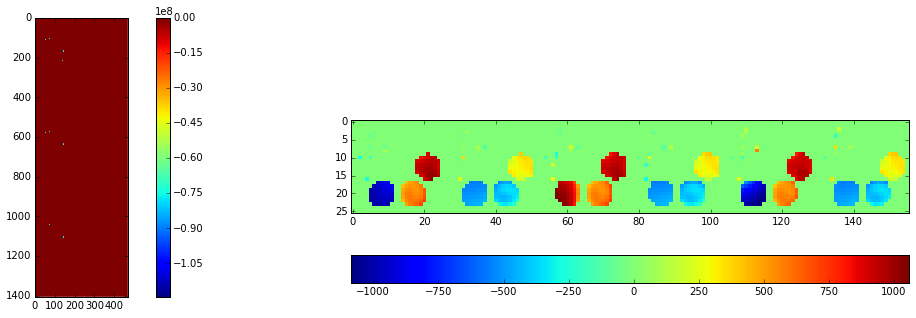

In [49]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron'),interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f nm"%src.wavefront.rms(-9)

##M2 segment Tx,Ty and Tz estimation

In [29]:
def randu(_n_=1,_m_=1,_a_=10e-6):
    return _a_*(2*np.random.rand(_n_,_m_)-1)

In [90]:
gmt.reset()
M1_gtt0 = np.zeros(2)
M2_txyz0 = np.zeros((7,3))
M2_stt = np.zeros(14)

### M1 global tip-tilt

In [91]:
M1_gtt0 = np.array([0.1,-0.02])*ARCSEC2RAD
gmt.M1.global_tiptilt(M1_gtt0[0],M1_gtt0[1])

### M1 segment tip-tilt

In [81]:
amp = 20*MAS2RAD
#randu(_a_=amp),randu(_a_=amp),randu(_a_=amp)
for k in range(7):
    gmt.M1.update(euler_angles=[amp,0,0],idx=k+1)
M1_Rxyz0 = gmt.M1.motion_CS.euler_angles
print "M1 Rx,Ry,Rz [mas]:"
print array_str(M1_Rxyz0/MAS2RAD,precision=2,suppress_small=True)

M1 Rx,Ry,Rz [mas]:
[[ 20.   0.   0.]
 [ 20.   0.   0.]
 [ 20.   0.   0.]
 [ 20.   0.   0.]
 [ 20.   0.   0.]
 [ 20.   0.   0.]
 [ 20.   0.   0.]]



Applying 10$\mu$m of uniformly random translation to M2 segment

In [82]:
#gmt.reset()
for k in range(7):
    gmt.M2.update(origin=[5e-6,-1e-6,1e-6],idx=k+1)
M2_txyz0 = gmt.M2.motion_CS.origin
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=2,suppress_small=True)

M2 Tx,Ty,Tz [micron]:
[[ 5. -1.  1.]
 [ 5. -1.  1.]
 [ 5. -1.  1.]
 [ 5. -1.  1.]
 [ 5. -1.  1.]
 [ 5. -1.  1.]
 [ 5. -1.  1.]]


and propagation to the WFS

on-axis WFE: 5.80 micron


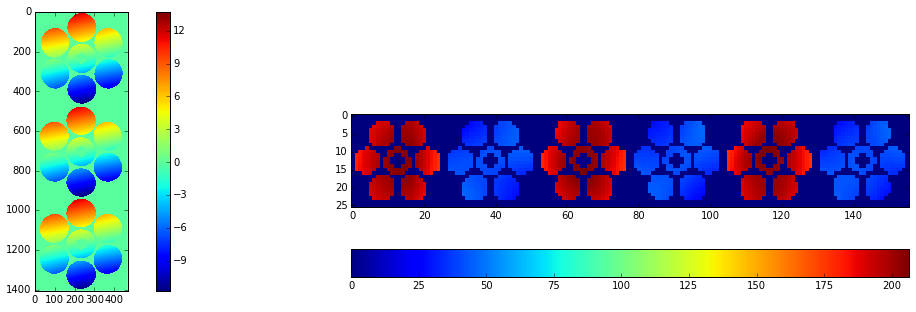

In [92]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts:

In [95]:
M2tt = pinv(D2tt)
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(origin = M2_txyz0[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/MAS2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

M2 segment tip-tilt [MAS] ([x,y] and magnitude):
[[-737.02  158.75]
 [-495.46 -609.52]
 [ 240.5  -768.74]
 [ 737.18 -159.59]
 [ 495.63  609.23]
 [-240.65  768.69]
 [ 795.74 -159.12]]
[ 0.75392542  0.78548561  0.80547908  0.7542612   0.78537404  0.80547494
  0.81148797]


on-axis WFE: 5483.47 nm


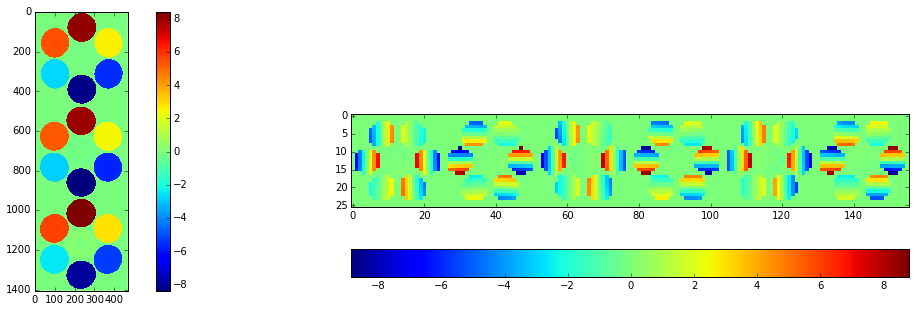

In [96]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
P = np.logical_and(P0,gs.amplitude.host())
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(P*gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f nm"%src.wavefront.rms(-9)

In [81]:
print src.wavefront.rms(-9)

[ 1.11756249]


Estimation of M1 global tip-tilt with:
 * either M2 Tx,Ty and Tz interaction matrix

In [97]:
M2xyz_2 = pinv(D2xyz_2)
M2_txyz = np.dot(M2xyz_2,wfs.valid_slopes.host().ravel())
_M2_txyz_ = M2_txyz0 - M2_txyz.reshape(7,-1)
for k in range(7):
    gmt.M2.update(origin = _M2_txyz_[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=3,suppress_small=True)
print "M2 Tx,Ty,Tz [micron]:"
print np.array_str(1e6*M2_txyz.reshape(7,-1),precision=3,suppress_small=True)

M2 Tx,Ty,Tz [micron]:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
M2 Tx,Ty,Tz [micron]:
[[ 0.096 -0.207 -4.072]
 [-0.203 -0.148 -2.723]
 [-0.264  0.083  1.317]
 [-0.036  0.284  4.039]
 [ 0.277  0.171  2.719]
 [ 0.292 -0.111 -1.308]
 [ 0.074  0.408 -0.   ]]


* or concatenated with M1 global tiptilt interaction matrix

In [98]:
D12 = np.concatenate((D1gtt_2,D2xyz_2),axis=1)
M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"
M2_txyz = com12[2:].reshape(7,-1)
_M2_txyz_ = M2_txyz0 - M2_txyz
for k in range(7):
    gmt.M2.update(origin = _M2_txyz_[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=3,suppress_small=True)
print "M2 Tx,Ty,Tz [micron]:"
print np.array_str(1e6*M2_txyz,precision=3,suppress_small=True)

M1 global tip-tilt: [ 0.1  -0.02] arcsec
M2 Tx,Ty,Tz [micron]:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
M2 Tx,Ty,Tz [micron]:
[[ 0.003  0.034 -0.017]
 [ 0.009  0.003  0.   ]
 [-0.002  0.001 -0.   ]
 [-0.003  0.025 -0.013]
 [ 0.01   0.001  0.002]
 [-0.002 -0.     0.001]
 [ 0.001 -0.001  0.   ]]


* or concatenated with M1 global tiptilt and M1 Zernike modes interaction matrices

(1784, 2)
(1784, 21)
(1784, 42)


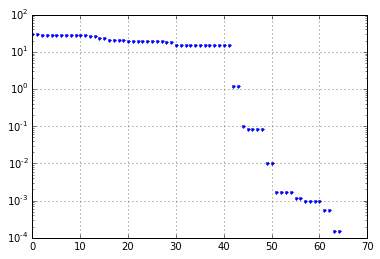

In [61]:
print D1gtt_2.shape
print D2xyz_2.shape
print D1z_2.shape
D12 = np.concatenate((D1gtt_2,D2xyz_2,D1z_2),axis=1)
U,S,V = np.linalg.svd(D12,full_matrices=False)
semilogy(np.arange(65),S,'.')
grid()
iS = 1/S
iS[50:] = 0
M12 = np.dot(V,np.dot(np.diag(iS),U.T))

In [63]:
#M12 = pinv(D12)
com12 = np.dot(M12,wfs.valid_slopes.host().ravel())
M1_gtt = com12[:2]
gmt.M1.global_tiptilt(M1_gtt0[0]-M1_gtt[0],M1_gtt0[1]-M1_gtt[1])
print "M1 global tip-tilt: " + array_str(M1_gtt/ARCSEC2RAD,precision=4,suppress_small=True) + " arcsec"

M1 global tip-tilt: [-0.0001  0.    ] arcsec


In [64]:
M2_txyz = com12[2:23].reshape(7,-1)
_M2_txyz_ = M2_txyz0 - M2_txyz
for k in range(7):
    gmt.M2.update(origin = _M2_txyz_[k,:].tolist(),
                  euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 Tx,Ty,Tz [micron]:"
print array_str(1e6*M2_txyz0,precision=3,suppress_small=True)
print "M2 Tx,Ty,Tz [micron]:"
print np.array_str(1e6*M2_txyz,precision=3,suppress_small=True)

M2 Tx,Ty,Tz [micron]:
[[ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]
 [ 0.  0.  0.]]
M2 Tx,Ty,Tz [micron]:
[[ 0.    -0.    -0.007]
 [-0.014 -0.     0.   ]
 [-0.    -0.    -0.005]
 [-0.019 -0.001 -0.001]
 [-0.    -0.    -0.013]
 [-0.001 -0.002  0.   ]
 [-0.    -0.    -0.   ]]


In [65]:
gmt.M1.zernike.a = com12[23:].reshape(7,-1)
gmt.M1.zernike.update()
print "M1 Zernike modes [nm]:"
print np.array_str(1e9*com12[23:].reshape(7,-1),precision=2,suppress_small=True)

M1 Zernike modes [nm]:
[[  0.     0.2   -1.27  -0.03   0.     0.  ]
 [ -0.    -0.01   0.01   1.23   0.04   0.01]
 [ -0.01   0.55  14.26   2.37 -11.75   2.61]
 [  2.17  -0.01  -0.04  -0.    -0.01  -0.03]
 [ -0.01  -0.     0.01  -0.     0.02  -0.  ]
 [  0.    -0.01   0.    -0.    -0.01   0.  ]
 [  0.01  -0.01  -0.01  -0.01  -0.01   0.  ]]


Compensation with M1 Tx,Ty and Tz

on-axis WFE: nan micron


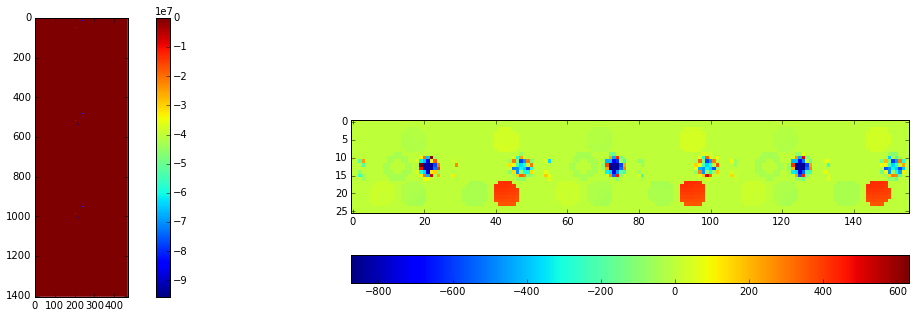

In [53]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron'),interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f micron"%src.wavefront.rms(-6)

Compensation with M2 segment tilts which are expected to be 0" each:

In [55]:
M2_stt += np.dot(M2tt,wfs.valid_slopes.host().ravel())
for k in range(7):
    gmt.M2.update(euler_angles=[-M2_stt[2*k],-M2_stt[2*k+1],0],idx=k+1)
print "M2 segment tip-tilt [MAS] ([x,y] and magnitude):"
print np.array_str(M2_stt.reshape(7,-1)/MAS2RAD,precision=2,suppress_small=True)
print np.hypot(M2_stt.reshape(7,-1)[:,0],M2_stt.reshape(7,-1)[:,1])/ARCSEC2RAD

M2 segment tip-tilt [MAS] ([x,y] and magnitude):
[[ 12.61   0.13]
 [  7.76   1.44]
 [  5.29   3.14]
 [  7.4   -0.15]
 [  5.8   -4.14]
 [  8.25  -0.44]
 [ -6.65  -0.13]]
[ 0.01260907  0.00789554  0.00615123  0.00739776  0.00712721  0.00825875
  0.006651  ]


and propagation again:

on-axis WFE: 26.60 nm


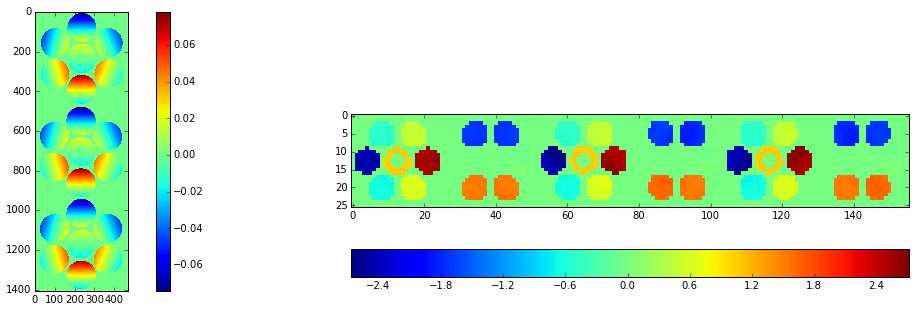

In [56]:
gs.reset()
gmt.propagate(gs)
wfs.reset()
wfs.analyze(gs)
fig, (ax1,ax2) = subplots(ncols=2)
fig.set_size_inches(22,5)
h1 = ax1.imshow(gs.phase.host(units='micron')-ps0,interpolation='none')
colorbar(h1,ax=ax1)
h2 = ax2.imshow(wfs.c.host(shape=(2*gs.size*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(h2,ax=ax2,orientation='horizontal')
src.reset()
gmt.propagate(src)
print "on-axis WFE: %.2f nm"%src.wavefront.rms(-9)

# AGWS closed-loop control

In [10]:
import scipy.io as io
data = io.loadmat('GMT-DOS-Estimation-SAO.mat')
D2tt = data['D2tt']
D2tt7 = data['D2tt7']
D1gtt_2 = data['D1gtt_2']
D2xyz_2 = data['D2xyz_2']
D1z_2 = data['D1z_2']
zmodes = [4,5]
zmodes.extend(range(6,10))
nZernCoefs = len(zmodes)

## Resetting

In [11]:
gs.reset()
wfs.reset()
gmt.reset()
ps0 = gs.phase.host(units='nm').T
com1 = np.zeros((23+7*nZernCoefs,1))
com2xyz0 = np.zeros((21,1))
com1[2:23] = com2xyz0
com2xyz = com1[2:23]
com2 = np.zeros((14,1))
com10  = np.zeros((2,1))
com20  = np.zeros((14,1))
zern_coefs0 = np.zeros((7,nZernCoefs))
M1_STT  = np.zeros((7,2))
M2 = np.linalg.pinv( D2tt )
D12 = np.concatenate( (D1gtt_2, D2xyz_2, D1z_2) , axis=1)
M12 = np.linalg.pinv( D12 )

## Initial conditions

In [12]:
%run GMT-DOS-Estimation-SAO.py

### M1 global tip-tilt

In [13]:
print M1_init['global tip-tilt [arcsec]']
com10 = (np.random.rand(2,1)*2-1)*M1_init['global tip-tilt [arcsec]']*ceo.constants.ARCSEC2RAD
print array_str(com10[:2]*ceo.constants.RAD2ARCSEC)
gmt.M1.global_tiptilt(com10[0],com10[1])
M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles

0
[[-0.]
 [-0.]]


### M1 segment tip-tilts

In [14]:
M1_STT[:,0] = (2*np.random.rand(7)-1)*M1_init["Rx [arcsec]"]*ceo.constants.ARCSEC2RAD
M1_STT[:,1] = (2*np.random.rand(7)-1)*M1_init["Ry [arcsec]"]*ceo.constants.ARCSEC2RAD
#com20[:,2] = (2*np.random.rand(7)-1)*M2_init["Rz [arcsec]"]*ceo.constants.ARCSEC2RAD
print array_str(M1_STT*ceo.constants.RAD2ARCSEC,precision=2)

[[ 1.55  1.8 ]
 [ 3.28 -0.72]
 [ 4.85  0.56]
 [ 2.29 -4.38]
 [-4.91  2.35]
 [ 2.16 -2.26]
 [-0.47 -2.46]]


### M1 bending modes (Zernike polynomials)

6


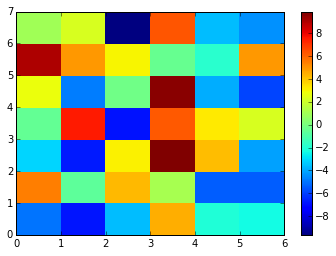

In [15]:
zern_coefs0 = (2*np.random.rand(7,nZernCoefs)-1)*M1_init['bending modes [micron]']*1e-6
zern_coefs0[:,6:] = 0
pcolor(zern_coefs0*1e9)
colorbar()
print nZernCoefs

### M2 x,y and z translations

In [16]:
com2xyz0 = np.zeros((7,3))
com2xyz0[:,0] = (2*np.random.rand(7)-1)*M2_init["Tx [micron]"]*1e-6
com2xyz0[:,1] = (2*np.random.rand(7)-1)*M2_init["Ty [micron]"]*1e-6
com2xyz0[:,2] = (2*np.random.rand(7)-1)*M2_init["Tz [micron]"]*1e-6
#com2xyz0 = (2*np.random.rand(21,1)-1)*50e-6
print array_str(com2xyz0*1e6,precision=2)
com2xyz0 = np.reshape(com2xyz0,(21,1))

[[-125.6    19.5    29.72]
 [ 223.82  253.32  -13.45]
 [ -54.6  -248.78    4.64]
 [-260.12  333.82  -23.15]
 [-322.74  373.99   28.27]
 [ 185.49 -350.25  -21.09]
 [ 337.82  277.26   -4.85]]


### M2 segment tip-tilts

In [17]:
print M2_init['Rx [arcsec]']
com20 = np.reshape(com20,(7,2))
com20[:,0] = (2*np.random.rand(7)-1)*M2_init["Rx [arcsec]"]*ceo.constants.ARCSEC2RAD
com20[:,1] = (2*np.random.rand(7)-1)*M2_init["Ry [arcsec]"]*ceo.constants.ARCSEC2RAD
#com20[:,2] = (2*np.random.rand(7)-1)*M2_init["Rz [arcsec]"]*ceo.constants.ARCSEC2RAD
print array_str(com20*ceo.constants.RAD2MAS,precision=2)
com20 = np.reshape(com20,(14,1))

7.2
[[-2410.04  1631.67]
 [ 7034.91 -3435.45]
 [-3536.56   180.23]
 [-4604.33  2992.62]
 [-3064.1   6422.73]
 [  139.32 -6617.19]
 [ 2309.97 -1480.86]]


### Noise condition

In [18]:
ron = 0
gs.magnitude = AGWS_magnitude
print gs.nPhoton*30*368*1e-10

3600143.77334


## Initial on-axis PSF and wavefront

In [19]:
from IPython.display import display, clear_output


gmt.reset()
gmt.M1.global_tiptilt(com10[0],com10[1])
#com1[23:] = np.random.randn(14,1)*1e-7
gmt.M1.zernike.a[:,zmodes] = zern_coefs0
gmt.M1.zernike.update()
com2 = np.array( com20 )

com2[0] = 100*ceo.constants.MAS2RAD

M1_O_GT = gmt.M1.motion_CS.origin
M1_A_GT = gmt.M1.motion_CS.euler_angles
M1_A_GT[:,:2] += M1_STT
for k in range(7):
    gmt.M1.update(origin=[M1_O_GT[k,0],M1_O_GT[k,1],M1_O_GT[k,2]],
                  euler_angles=[M1_A_GT[k,0],M1_A_GT[k,1],M1_A_GT[k,2]],idx=k+1)
    gmt.M2.update(origin=[com2xyz0[3*k],com2xyz0[3*k+1],com2xyz0[3*k+2]],
                  euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    

Initial WFE rms: 107261.61nm


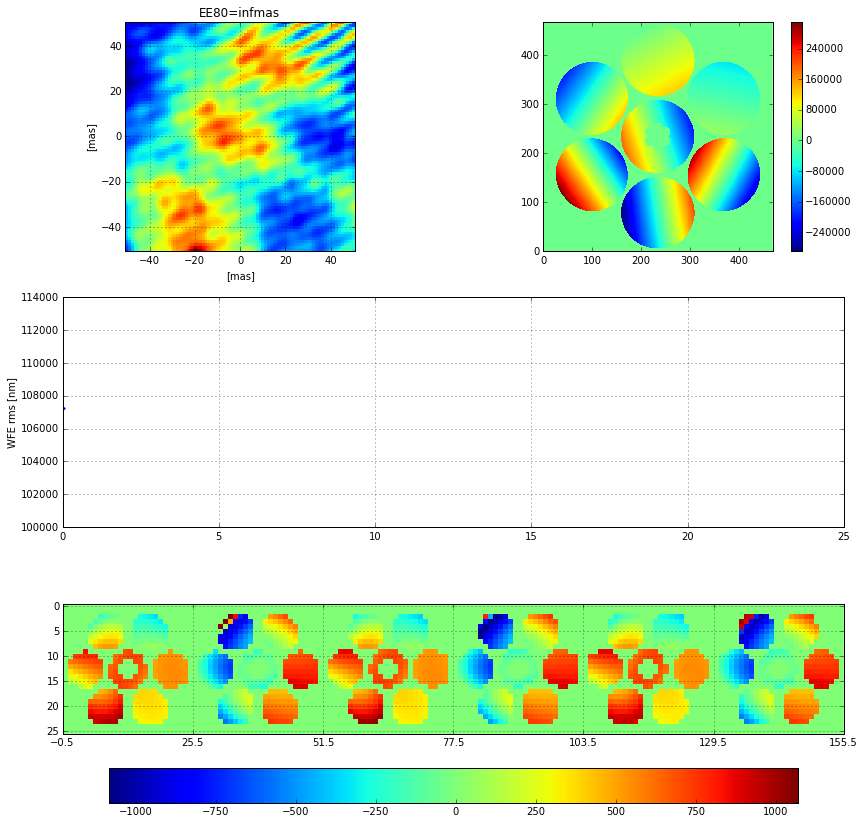

In [20]:
gs.reset()
wfs.reset()

src.reset()
gmt.propagate(src)
imgr.reset()
imgr.propagate(src)

fig = figure()
fig.set_size_inches((14,14))
ax1 = plt.subplot2grid((3,2),(0,0))
ax2 = plt.subplot2grid((3,2),(0,1))
ax3  = plt.subplot2grid((3,2),(1,0), colspan=2)
ax4 = plt.subplot2grid((3,2),(2,0), colspan=2)

psf = imgr.frame.host()

h1 = ax1.imshow(psf,interpolation='none',origin='lower',extent=[x*px_scale*ceo.constants.RAD2MAS for x in [-40,40,-40,40]])
ax1.grid()
ax1.set_xlabel('[mas]')
ax1.set_ylabel('[mas]')
ax1.set_title("EE80=%.2fmas"%ee80(psf,px_scale))

h2 = ax2.imshow(src.phase.host(units='nm'),interpolation='none',origin='lower')
colorbar(h2,ax=ax2)

gmt.propagate(gs)
wfs.propagate(gs)
wfs.readOut(30,ron)
wfs.process()

n1Step = 25
wfe_rms = np.zeros(n1Step+1)
wfe_rms[0] = src.wavefront.rms(-9)
h3, = ax3.plot(wfe_rms[:1],'.-')
ax3.grid()
ax3.set_ylabel("WFE rms [nm]")
ax3.set_xlim((0,n1Step))
ax3.set_autoscaley_on(True)
print "Initial WFE rms: %6.2fnm"%wfe_rms[0]

c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
h4 = ax4.imshow(c,interpolation='none')
colorbar(h4,ax=ax4,orientation='horizontal')
h4.set_label("[mas]")
ax4.set_xticks(np.arange(0,N_LENSLET*(2*gs.N_SRC+1),N_LENSLET)-0.5)
ax4.grid()

## Stacking images

In [21]:
com2xyz = com2xyz0
M2tt7 = np.linalg.pinv(D2tt7)
nStep = 20
M2_R = np.zeros((14,nStep))
M2_R[:,0] = com20.ravel()
a23 = np.zeros((14,gs.size,nStep-1))
com2 = np.zeros((14,1))

In [32]:
gs.reset()
gmt.propagate(gs)
print np.dot(M2tt7,np.ravel(sts.tiptilt(gs) - a230))*ceo.constants.RAD2MAS
for kStep in range(nStep-1):
    gs.reset()
    gmt.propagate(gs)
    a23[:,:,kStep] = sts.tiptilt(gs) - a230
    com2 -= 0.5*np.dot(M2tt7,a23[:,:,kStep].ravel()).reshape(-1,1)
#    print M2_R/mas2rad
#    print M2_R.shape
    for k in range(7):
        R = [ com2[2*k], com2[2*k+1], 0]
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],0*com2xyz[3*k+2]],
                      euler_angles=R,idx=k+1)

[ 18880.99920584  30848.23730261 -19020.08958506  30848.78982809
 -35875.07720978  -1584.98389905 -16440.27466835 -33250.3129313
  15581.28663647 -31430.28962142  33477.24926335  -4949.26016536
 -18581.76573232 -32049.22931141]


[[-18768.45236549 -30898.17118328  19097.47194136 -30865.80619068
   35818.70373337   1676.49418239  16457.2594496   33273.10789569
  -15618.52854044  31499.07944998 -32855.65133655   3853.59236836
   18502.59971215  32060.40731916]]


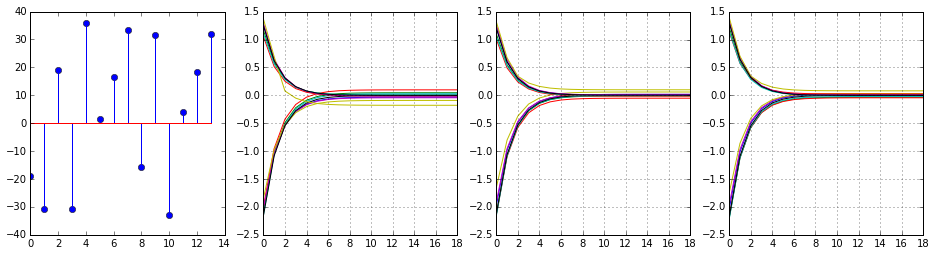

In [33]:
fig_, axs = plt.subplots(ncols=4)
fig_.set_size_inches(16,4)
h11=axs[0].stem(com2*ceo.constants.RAD2ARCSEC)
for k in range(1,gs.size+1):
    hs=axs[k].plot(a23[:,k-1,:].T*1e6)
    axs[k].grid()
print com2.T*ceo.constants.RAD2MAS

## Closing the loop

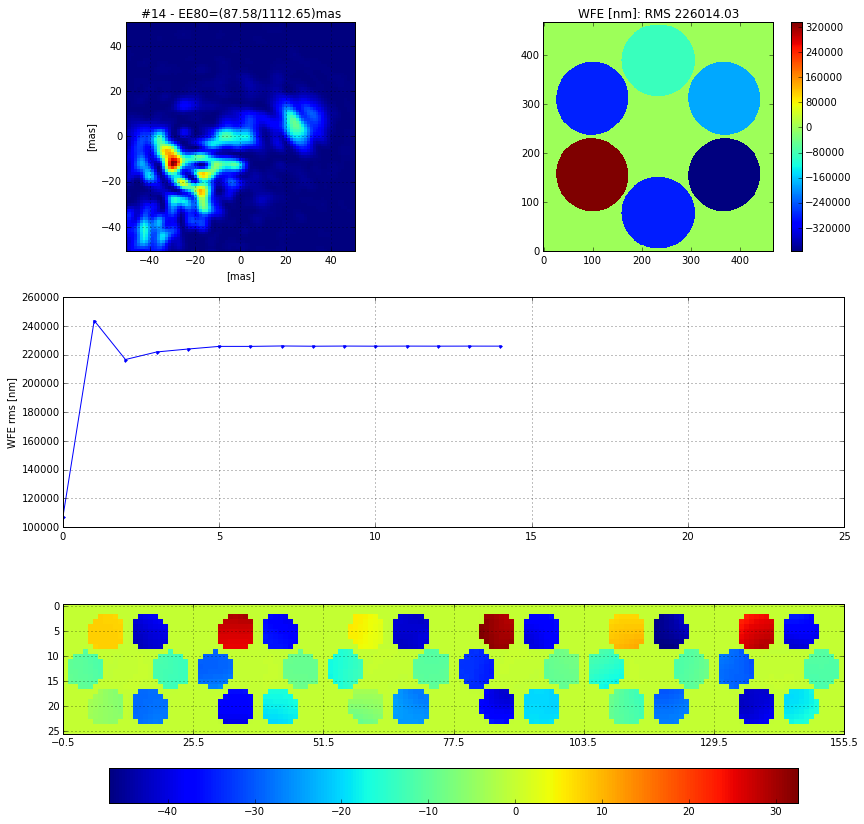

In [22]:
from ceo.constants import ARCSEC2RAD, MAS2RAD
M1_gtt_int = np.zeros((2,1))
com2xyz = com2xyz0
k1Step = 0
idx = 0
closed_loop = True
#while closed_loop:
for k1Step in range(15):
    
    %run GMT-DOS-Estimation-SAO.py
    
    ron = read_out_noise
    gs.magnitude = AGWS_magnitude
    
    gs.reset()
    gmt.propagate(gs)
    com2 -= np.dot(M2tt7,np.ravel(sts.tiptilt(gs) - a230)).reshape(-1,1)

    for k2Step in range(5):
        gs.reset()
        gmt.propagate(gs)
        wfs.reset()
        #wfs.analyze(gs)
        wfs.propagate(gs)
        wfs.readOut(30,ron)
        wfs.process()
        com2 -= g2*np.dot(M2,wfs.valid_slopes.host().T)
        for k in range(7):
            gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                          euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)
        """
        src.reset()
        gmt.propagate(src)

        wfe = src.phase.host(units='nm')
        idx += 1
        idx = idx%(n1Step+1)
        wfe_rms[idx] = 1e9*src.wavefront.rms()
        """

    gs.reset()
    gmt.propagate(gs)
    wfs.reset()
    wfs.propagate(gs)
    wfs.readOut(30,ron)
    wfs.process()
    #wfs.analyze(gs)

    com1_est = np.dot(M12,wfs.valid_slopes.host().T)
    com2xyz = com2xyz - g1*com1_est[2:23]
    M1_gtt_est = com1_est[:2]
    #M1_idx = np.abs(M1_gtt_est)>0.1*ARCSEC2RAD
    #M1_gtt_est[M1_idx] = np.sign(M1_gtt_est[M1_idx])*0.1*ARCSEC2RAD
    M1_gtt_int += g1*M1_gtt_est
    M1_gtt = com10[:2] - M1_gtt_int
    gmt.M1.global_tiptilt(M1_gtt[0],M1_gtt[1])
    gmt.M1.zernike.a[:,zmodes] -=  g1*com1_est[23:].reshape(7,-1)
    gmt.M1.zernike.update()
    M1_O_GT = gmt.M1.motion_CS.origin
    M1_A_GT = gmt.M1.motion_CS.euler_angles
    M1_A_GT[:,:2] += M1_STT
    for k in range(7):
        gmt.M1.update(origin=[M1_O_GT[k,0],M1_O_GT[k,1],M1_O_GT[k,2]],
                  euler_angles=[M1_A_GT[k,0],M1_A_GT[k,1],M1_A_GT[k,2]],idx=k+1)
        gmt.M2.update(origin=[com2xyz[3*k],com2xyz[3*k+1],com2xyz[3*k+2]],
                     euler_angles=[ com2[2*k], com2[2*k+1], 0],idx=k+1)

    src.reset()
    gmt.propagate(src)
    imgr.reset()
    imgr.propagate(src)

    wfe = src.phase.host(units='nm')
    idx += 1
    idx = idx%(n1Step+1)
    wfe_rms[idx] = 1e9*src.wavefront.rms()
    
    ax3.relim()
    ax3.autoscale_view(scaley=True)
    
    if k1Step<n1Step:
        h3.set_data(arange(idx),wfe_rms[:idx])
    else:
        h3.set_data(arange(n1Step+1),np.roll(wfe_rms,-idx-1))
    
    psf = imgr.frame.host()
    src.reset()
    gmt.propagate(src,where_to="focal plane")
    h1.set_data(psf)
    h1.set_clim((psf.min(),psf.max()))
    ax1.set_title("#%d - EE80=(%.2f/%.2f)mas"%(k1Step,ee80(psf,px_scale),src.rays.ee80()*ceo.constants.RAD2MAS))

    h2.set_data(wfe)
    h2.set_clim((wfe.min(),wfe.max()))
    ax2.set_title( "WFE [nm]: RMS %4.2f"%wfe_rms[idx])
        
    c = wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T
    h4.set_data(c)
    h4.set_clim((c.min(),c.max()))

    clear_output(wait=True)
    display(fig)
plt.close()

In [28]:
src.rays.ee80()

ValueError: zero-size array to reduction operation maximum which has no identity

In [ ]:
print com2*ceo.constants.RAD2ARCSEC

## Wavefront error rms

In [ ]:
plot(wfe_rms[:20],'.-')
grid()
xlabel('Steps')
ylabel('WFE [nm]')
print wfe_rms[0]

In [ ]:
wfe_rms[0:20]

In [ ]:
wfs.reset()
wfs.analyze(gs)
fig_c = figure()
fig_c.set_size_inches((12,8))
imshow(wfs.c.host(shape=(2*N_GS*N_LENSLET,N_LENSLET),units='mas').T,interpolation='none')
colorbar(orientation='horizontal')

In [ ]:
P = src.rays.piston_mask
print P[0].shape
imshow(np.reshape(P[0][0,:],(nPx,nPx)))
print P[0].sum(axis=1)
print gs.wavefront.amplitude.host()[0,:].sum()
src.size

In [ ]:
P1 = P[0]
P1 = np.rollaxis(np.array(P),0,3)
src.rays.
u = arange(nPx)
x,y = meshgrid(u,u)
x = x.reshape(1,-1,1)
y = y.reshape(1,-1,1)
xc = np.sum(x*P1,axis=1)/P1.sum(axis=1)
yc = np.sum(y*P1,axis=1)/P1.sum(axis=1)
print xc
print yc

In [ ]:
fig,ax0 = subplots()
#ax0.imshow(np.reshape(P[0][0,:],(nPx,nPx)))
ax0.scatter(xc,yc)


In [ ]:
x.shape

In [ ]:
yc_ = yc.reshape(7,1,3)
print yc

In [ ]:
imshow(y.reshape(nPx,nPx)-yc[0,0])
colorbar()

In [ ]:
P1.shape

In [ ]:
yc_[:,0,1]

In [ ]:
Z2 = (x - xc.reshape(7,1,3))*P1
Z3 = (y - yc.reshape(7,1,3))*P1

In [ ]:
print Z2.shape

In [ ]:
fig, (ax1,ax2) = subplots(nrows=1,ncols=2)
h1 = ax1.imshow(np.reshape(Z2[:,:,1].sum(axis=0),(nPx,nPx)))
colorbar(h1,ax=ax1)
h2 = ax2.imshow(np.reshape(Z3[:,:,2].sum(axis=0),(nPx,nPx)))
colorbar(h2,ax=ax2)

In [ ]:
W = np.rollaxis( gs.wavefront.phase.host(shape=(1,3,nPx*nPx)), 1, 3)
W.shape

In [ ]:
imshow(np.reshape(W[0,:,0],(nPx,nPx)))

In [ ]:
a2 = np.sum(W*Z2,axis=1)/np.sum(Z2*Z2,axis=1)

In [ ]:
a3 = np.sum(W*Z3,axis=1)/np.sum(Z3*Z3,axis=1)

In [ ]:
gs.reset()

In [ ]:
a2.shape